In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings(action="ignore")

In [3]:
np.random.seed(21)

In [4]:
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

In [5]:
train.shape

(1460, 81)

In [6]:
test.shape

(1459, 80)

# Duplicates

In [7]:
def check_duplicates(data):
    idsUnique = len(set(data.Id))
    idsTotal = data.shape[0]
    idsDupli = idsTotal - idsUnique
    print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

In [8]:
check_duplicates(train)

There are 0 duplicate IDs for 1460 total entries


In [9]:
check_duplicates(test)

There are 0 duplicate IDs for 1459 total entries


# Outliers

There seems to be 2 extreme outliers on the bottom right, really large houses that sold for really cheap. More generally, the author of the dataset recommends removing 'any houses with more than 4000 square feet' from the dataset.
Reference : https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

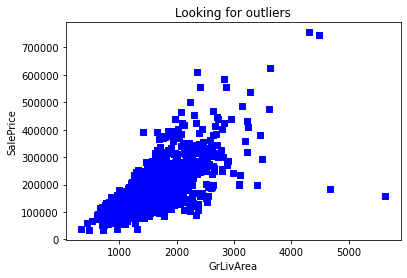

In [10]:
plt.scatter(train.GrLivArea, train.SalePrice, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

In [12]:
def drop_outliers(alldata):
    alldata = alldata[alldata.GrLivArea < 4000]
    return alldata

In [16]:
train[train.GrLivArea >= 4000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


# Missing data

In [12]:
def missing_data_chart(data):
    missing = data.isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(inplace=True)
    missing.plot.bar()

In [13]:
def missing_data_table(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
    total = total[total > 0]
    percent = percent[percent > 0]
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head(30)

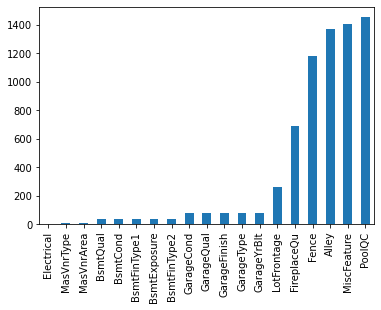

In [14]:
missing_data_chart(train)

In [15]:
missing_data_table(train)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


# Удаление пропущенных

In [16]:
def drop_missing_data_columns(data, threshold):
    data = data[data.columns[data.isnull().mean() < threshold]]
    return data

In [17]:
def drop_missing_data_rows(data, threshold):
    data = data.loc[data.isnull().mean(axis=1) < threshold]
    return data

# Заполнение пропущенных значений

In [18]:
def fillna_0(data, columns):
    for column in columns:
        data.loc[:, column] = data.loc[:, column].fillna(0)
    return data

In [19]:
def fillna_value(data, columns, value):
    for column in columns:
        data.loc[:, column] = data.loc[:, column].fillna(value)
    return data

In [20]:
def fillna_mean(data, columns):
    temp = data[columns]
    print("NAs for numerical features in train : " + str(temp.isnull().values.sum()))
    temp = temp.fillna(temp.mean())
    data[columns] = temp
    print("Remaining NAs for numerical features in train : " + str(temp.isnull().values.sum()))
    return data

In [21]:
def fillna_median(data, columns):
    temp = data[columns]
    print("NAs for numerical features in train : " + str(temp.isnull().values.sum()))
    temp = temp.fillna(temp.median())
    data[columns] = temp
    print("Remaining NAs for numerical features in train : " + str(temp.isnull().values.sum()))
    return data

In [22]:
def recodeMissing(dataraw):
    columns_0 = ["BedroomAbvGr", "BsmtFullBath", "BsmtHalfBath", "BsmtUnfSF", "EnclosedPorch", "Fireplaces", "GarageArea", "GarageCars", "HalfBath", "KitchenAbvGr", "LotFrontage", "MasVnrArea", "MiscVal", "OpenPorchSF", "PoolArea", "ScreenPorch", "TotRmsAbvGrd", "WoodDeckSF"]
    columns_No = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Fence", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "MiscFeature", "PoolQC"]
    columns_None = ["Alley", "MasVnrType"]
    columns_N = ["CentralAir", "PavedDrive"]
    columns_Norm = ["Condition1", "Condition2"]
    columns_TA = ["ExterCond", "ExterQual", "HeatingQC", "KitchenQual"]
    columns_Typ = ["Functional"]
    columns_Reg = ["LotShape"]
    columns_Normal = ["SaleCondition"]
    columns_AllPub = ["Utilities"]
    columns_SBrkr = ['Electrical']
    dataraw = fillna_0(dataraw, columns_0)
    dataraw = fillna_value(dataraw, columns_No, "No")
    dataraw = fillna_value(dataraw, columns_None, "None")
    dataraw = fillna_value(dataraw, columns_N, "N")
    dataraw = fillna_value(dataraw, columns_Norm, "Norm")
    dataraw = fillna_value(dataraw, columns_Typ, "Typ")
    dataraw = fillna_value(dataraw, columns_Reg, "Reg")
    dataraw = fillna_value(dataraw, columns_Normal, "Normal")
    dataraw = fillna_value(dataraw, columns_AllPub, "AllPub")
    dataraw = fillna_value(dataraw, columns_SBrkr, "SBrkr")
    return dataraw

# Чистка категорий

In [23]:
def clean(allData):
    allData["Exterior2nd"] = allData["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    allData["GarageYrBlt"] = allData["GarageYrBlt"].where(allData.GarageYrBlt <= 2010, allData.YearBuilt)
    return allData

# Кодирование порядковых категорий

In [24]:
translist1=['BsmtQual','BsmtCond', 'ExterCond', 'ExterQual','GarageCond','GarageQual','KitchenQual',
           'FireplaceQu','PoolQC','HeatingQC']
thisvals1 = ['Ex','Gd','TA','Fa','Po','No']

In [25]:
translist2=["BsmtFinType1", "BsmtFinType2"]
thisvals2 = ['GLQ','ALQ','BLQ','Rec','LwQ','Unf']

In [26]:
translist3=["BsmtExposure"]
thisvals3 = ['Gd','Av','Mn','No']

In [27]:
def recodeQualRatings(alldata, translist, thisvals):
    chgdict = {}
    addtoratio=[]
    for t in translist:
        alldata.loc[:,t+'num']=alldata[t]
        thisval=len(thisvals)-1
        chgdict[t+'num']={}
        for thisVal in thisvals:
            chgdict[t+'num'][thisVal]=thisval
            thisval-=1
        chgdict[t+'num']['No']=0
        alldata.loc[:,t+'num']=alldata[t+'num'].fillna('No')
    alldata.replace(to_replace=chgdict,inplace=True)
    return alldata

# Разбиение временных признаков

In [28]:
years = ['YrSold','YearRemodAdd','GarageYrBlt','YearBuilt']

In [29]:
def chunkYears(alldata,years):
    for y in years:
        alldata[y+'decade']=(alldata[y]/10).round()
        alldata.loc[:,y+'decade']=alldata.loc[:,y+'decade'].fillna(999)
        alldata.loc[:,y+'decade']=alldata.loc[:,y+'decade'].astype('str')
        alldata.loc[:,y]=2010-alldata[y]
        alldata.loc[alldata[y] < 0,y] = 0
    alldata['newBuild']=1*[alldata['YrSold']<=1][0]
    return alldata

# Упрощение категорий

In [30]:
def simplificationsFeatures(allData):
    allData["SimplBsmtQual"] = allData.BsmtQualnum.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
    allData["SimplBsmtCond"] = allData.BsmtCondnum.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
    allData["SimplExterCond"] = allData.ExterCondnum.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
    allData["SimplExterQual"] = allData.ExterQualnum.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
    allData["SimplGarageCond"] = allData.GarageCondnum.replace({1 : 1, # bad
                                                         2 : 1, 3 : 1, # average
                                                         4 : 2, 5 : 2 # good
                                                        })
    allData["SimplGarageQual"] = allData.GarageQualnum.replace({1 : 1, # bad
                                                         2 : 1, 3 : 1, # average
                                                         4 : 2, 5 : 2 # good
                                                        })
    allData["SimplKitchenQual"] = allData.KitchenQualnum.replace({1 : 1, # bad
                                                           2 : 1, 3 : 1, # average
                                                           4 : 2, 5 : 2 # good
                                                          })
    allData["SimplFireplaceQu"] = allData.FireplaceQunum.replace({1 : 1, # bad
                                                           2 : 1, 3 : 1, # average
                                                           4 : 2, 5 : 2 # good
                                                          })    
    allData["SimplPoolQC"] = allData.PoolQCnum.replace({1 : 1, 2 : 1, # average
                                                 3 : 2, 4 : 2 # good
                                                })
    allData["SimplHeatingQC"] = allData.HeatingQCnum.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
    
    allData["SimplOverallQual"] = allData.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                           4 : 2, 5 : 2, 6 : 2, # average
                                                           7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                          })
    allData["SimplOverallCond"] = allData.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                           4 : 2, 5 : 2, 6 : 2, # average
                                                           7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                          })

    allData["SimplBsmtFinType1"] = allData.BsmtFinType1num.replace({1 : 1, # unfinished
                                                             2 : 1, 3 : 1, # rec room
                                                             4 : 2, 5 : 2, 6 : 2 # living quarters
                                                            })
    allData["SimplBsmtFinType2"] = allData.BsmtFinType2num.replace({1 : 1, # unfinished
                                                             2 : 1, 3 : 1, # rec room
                                                             4 : 2, 5 : 2, 6 : 2 # living quarters
                                                            })
    return allData

# Объединение категорий

In [31]:
def  combinationsFeatures(allData):
    # Overall quality of the house
    allData["OverallGrade"] = allData["OverallQual"] * allData["OverallCond"]
    # Overall quality of the garage
    allData["GarageGrade"] = allData["GarageQualnum"] * allData["GarageCondnum"]
    # Overall quality of the exterior
    allData["ExterGrade"] = allData["ExterQualnum"] * allData["ExterCondnum"]
    # Overall kitchen score
    allData["KitchenScore"] = allData["KitchenAbvGr"] * allData["KitchenQualnum"]
    # Overall fireplace score
    allData["FireplaceScore"] = allData["Fireplaces"] * allData["FireplaceQunum"]
    # Overall garage score
    allData["GarageScore"] = allData["GarageArea"] * allData["GarageQualnum"]
    # Overall pool score
    allData["PoolScore"] = allData["PoolArea"] * allData["PoolQCnum"]
    # Simplified overall quality of the house
    allData["SimplOverallGrade"] = allData["SimplOverallQual"] * allData["SimplOverallCond"]
    # Simplified overall quality of the exterior
    allData["SimplExterGrade"] = allData["SimplExterQual"] * allData["SimplExterCond"]
    # Simplified overall pool score
    allData["SimplPoolScore"] = allData["PoolArea"] * allData["SimplPoolQC"]
    # Simplified overall garage score
    allData["SimplGarageScore"] = allData["GarageArea"] * allData["SimplGarageQual"]
    # Simplified overall fireplace score
    allData["SimplFireplaceScore"] = allData["Fireplaces"] * allData["SimplFireplaceQu"]
    # Simplified overall kitchen score
    allData["SimplKitchenScore"] = allData["KitchenAbvGr"] * allData["SimplKitchenQual"]
    # Total number of bathrooms
    allData["TotalBath"] = allData["BsmtFullBath"] + (0.5 * allData["BsmtHalfBath"]) + \
    allData["FullBath"] + (0.5 * allData["HalfBath"])
    # Total SF for house (incl. basement)
    allData["AllSF"] = allData["GrLivArea"] + allData["TotalBsmtSF"]
    # Total SF for 1st + 2nd floors
    allData["AllFlrsSF"] = allData["1stFlrSF"] + allData["2ndFlrSF"]
    # Total SF for porch
    allData["AllPorchSF"] = allData["OpenPorchSF"] + allData["EnclosedPorch"] + \
    allData["3SsnPorch"] + allData["ScreenPorch"]
    # Has masonry veneer or not
    allData["HasMasVnr"] = allData.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                                   "Stone" : 1, "None" : 0})
    # House completed before sale or not
    allData["BoughtOffPlan"] = allData.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                          "Family" : 0, "Normal" : 0, "Partial" : 1})
    return allData

# Полиномиальные признаки

In [32]:
def polynomialsFeatures(allData, columns):
    for col in columns:
        allData[col+'-2'] = allData.loc[:,col]**2
        allData[col+'-3'] = allData.loc[:,col]**3
        allData[col+'-sqrt'] = np.sqrt(np.absolute(allData.loc[:,col]))
    return allData

# Выбор функций

In [33]:
train_transform = copy.deepcopy(train)
test_transform = copy.deepcopy(test)

### Выбросы

In [34]:
train_transform = drop_outliers(train_transform)

In [35]:
train_transform.shape

(1456, 81)

### Удаление пропущенных значений

In [36]:
#train_transform = drop_missing_data_columns(train_transform, 0.75)
#train_transform.shape
#missing_data_table(train_transform)

In [37]:
#train_transform = drop_missing_data_rows(train_transform, 0.75)
#train_transform.shape
#missing_data_table(train_transform)

### Заполнение пропущенных значений

Категории

In [38]:
train_transform = recodeMissing(train_transform)
test_transform = recodeMissing(test_transform)

Числовые

In [39]:
numerical_features = train_transform.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")

In [40]:
train_transform = fillna_median(train_transform, numerical_features)
test_transform = fillna_median(test_transform, numerical_features)

NAs for numerical features in train : 81
Remaining NAs for numerical features in train : 0
NAs for numerical features in train : 81
Remaining NAs for numerical features in train : 0


In [41]:
#missing_data_chart(train_transform)

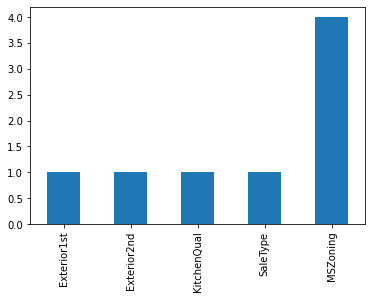

In [42]:
missing_data_chart(test_transform)

### Чистка категорий

In [43]:
train_transform = clean(train_transform)
test_transform = clean(test_transform)

### Кодирование порядковых категорий

In [44]:
train_transform = recodeQualRatings(train_transform, translist1, thisvals1)
test_transform = recodeQualRatings(test_transform, translist1, thisvals1)
train_transform = recodeQualRatings(train_transform, translist2, thisvals2)
test_transform = recodeQualRatings(test_transform, translist2, thisvals2)
train_transform = recodeQualRatings(train_transform, translist3, thisvals3)
test_transform = recodeQualRatings(test_transform, translist3, thisvals3)

### Разбиение временных признаков

In [45]:
train_transform = chunkYears(train_transform, years)
test_transform = chunkYears(test_transform, years)

### Упрощение категорий

In [46]:
train_transform = simplificationsFeatures(train_transform)
test_transform = simplificationsFeatures(test_transform)

### Объединение категорий

In [47]:
train_transform = combinationsFeatures(train_transform)
test_transform = combinationsFeatures(test_transform)

### Полиномиальные признаки

In [48]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   

In [49]:
corr.SalePrice[1:11].index

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd'],
      dtype='object')

In [50]:
train_transform = polynomialsFeatures(train_transform, corr.SalePrice[1:11].index)
test_transform = polynomialsFeatures(test_transform, corr.SalePrice[1:11].index)

# Сохранение результатов

In [51]:
train_transform.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,FullBath-sqrt,TotRmsAbvGrd-2,TotRmsAbvGrd-3,TotRmsAbvGrd-sqrt,YearBuilt-2,YearBuilt-3,YearBuilt-sqrt,YearRemodAdd-2,YearRemodAdd-3,YearRemodAdd-sqrt
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,1.414214,64,512,2.828427,49,343,2.645751,49,343,2.645751
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,1.414214,36,216,2.449490,1156,39304,5.830952,1156,39304,5.830952
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,1.414214,36,216,2.449490,81,729,3.000000,64,512,2.828427
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,1.000000,49,343,2.645751,9025,857375,9.746794,1600,64000,6.324555
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,1.414214,81,729,3.000000,100,1000,3.162278,100,1000,3.162278


In [52]:
train_transform.shape

(1456, 162)

In [53]:
test_transform.shape

(1459, 161)

In [54]:
train_transform.to_csv("transform/train_transform_after_cleaning.csv", index = False)
test_transform.to_csv("transform/test_transform_after_cleaning.csv", index = False)